## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from plotnine import *
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


In [2]:
heart = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")
heart['diagnosis'] = heart['diagnosis'].replace({'No Disease': 0,
                                                 'Disease': 1})
heart.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,0
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,1
2,Miles Wolf,62,0,3,130,263,1,97,0
3,Mikaila Block,43,1,1,115,303,1,181,1
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,1


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [3]:
# Classifiying X and y
X = heart[['age', 'chol']]
y = heart['diagnosis']




# Column Transformers
ct = ColumnTransformer(
[
    ('dummify', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),make_column_selector(dtype_include = object)),
    ('standardize', StandardScaler(), make_column_selector(dtype_include=np.number))
],
    remainder = 'passthrough')

In [4]:
# Logistic Regression Pipeline
log_pipe = Pipeline(
    [
        ('preprocessing', ct),
        ('logistic_regression', LogisticRegression())
    ]
)

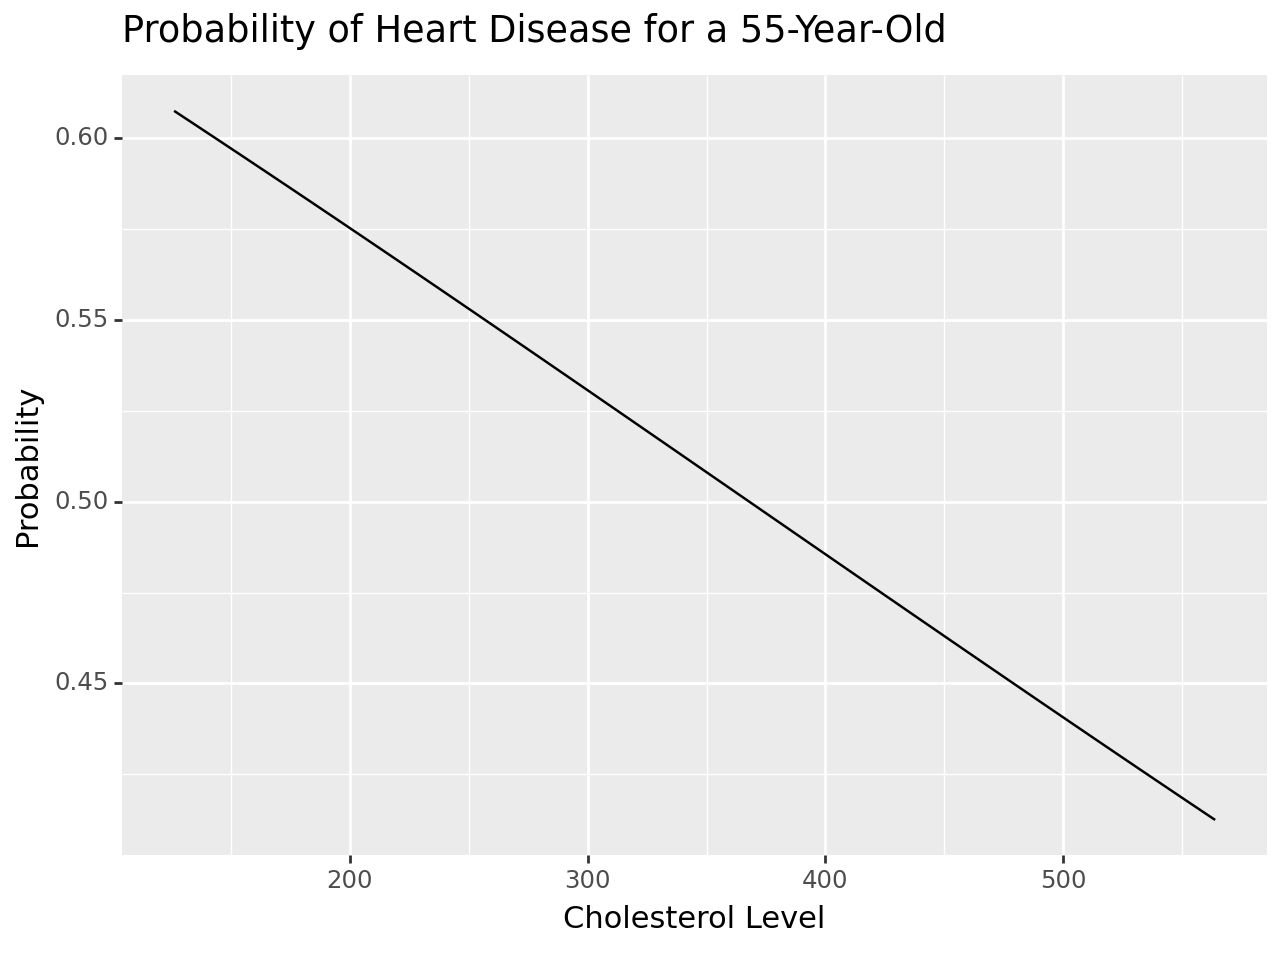

<Figure Size: (640 x 480)>

In [5]:
# Fitting the model to the data
log_pipe_fitted = log_pipe.fit(X, y)

# Making predictions
y_pred_prob = log_pipe.predict_proba(X)

cholesterol_range = np.linspace(X['chol'].min(), X['chol'].max(), 100)
age_55_data = np.ones_like(cholesterol_range) * 55
X_plot = pd.DataFrame({'age': age_55_data, 'chol': cholesterol_range})
probabilities = log_pipe.predict_proba(X_plot)[:, 1]

plot_data = pd.DataFrame({'Cholesterol Level': cholesterol_range, 'Probability of Heart Disease': probabilities})


(ggplot(plot_data, aes(x='Cholesterol Level',
                       y='Probability of Heart Disease')) +
 geom_line() +
 labs(title='Probability of Heart Disease for a 55-Year-Old',
      x='Cholesterol Level',
      y='Probability')
)

In [36]:
# For a patient for aged 55
log_pipe_fitted.named_steps['logistic_regression'].coef_

array([[-0.4276609 , -0.09574187]])

In [41]:
log_pipe_fitted.named_steps['logistic_regression'].intercept_

array([0.27024336])

predicted-HD = 0.27 - 0.427*age - 0.0957*chol

For someone aged 55, chol calculation:
(1 - 0.27 + 0.427*55)/-0.0957 = 253.03

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [6]:
# LDA Pipeline
lda_pipe = Pipeline(
    [
        ('preprocessing', ct),
        ('lda', LinearDiscriminantAnalysis())
    ]
)

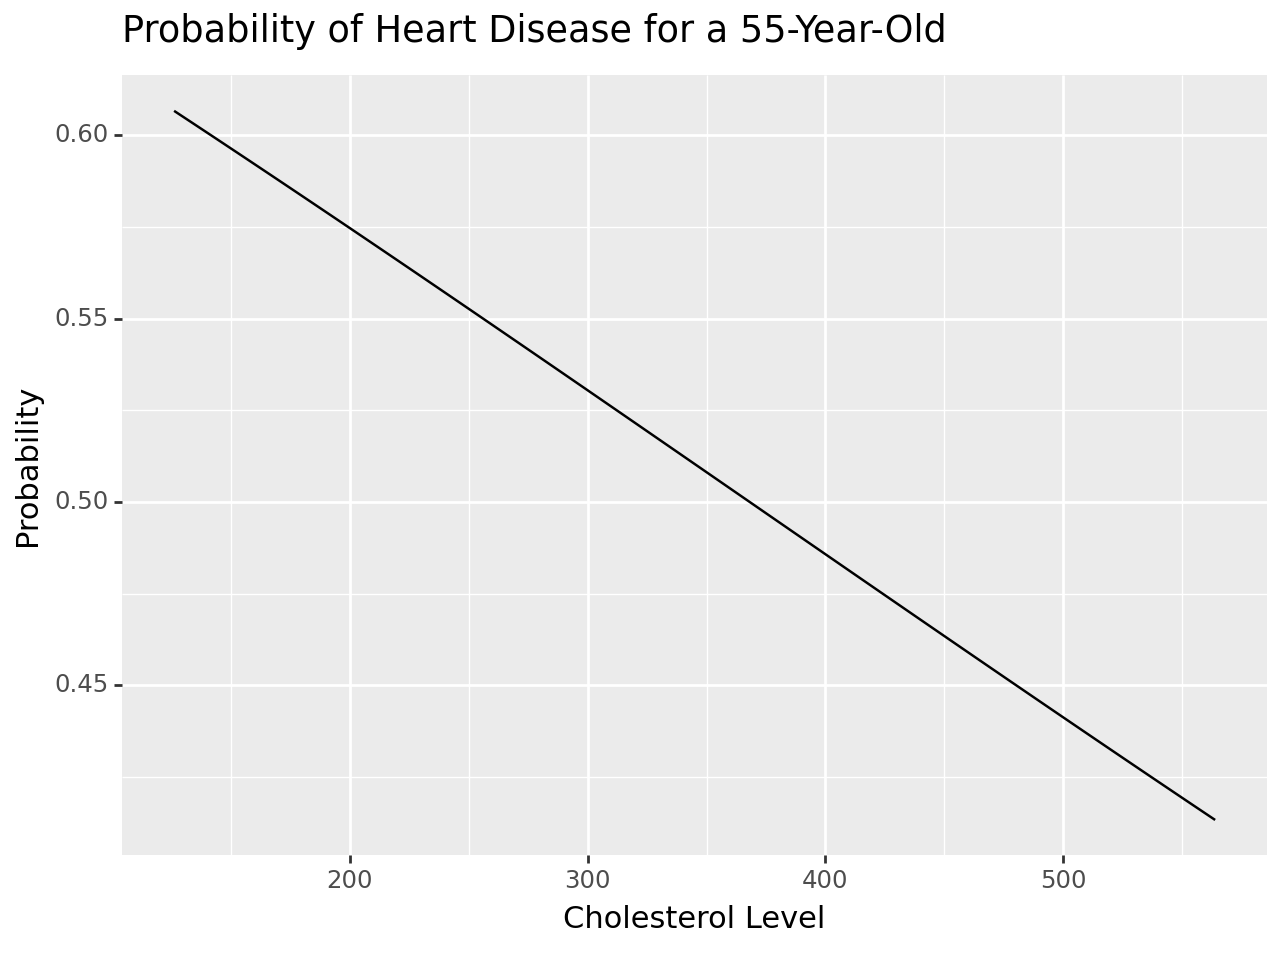

<Figure Size: (640 x 480)>

In [25]:
# Fitting the data
lda_fit = lda_pipe.fit(X, y)

# Probabilities and plotting
probabilities_lda = lda_pipe.predict_proba(X_plot)[:, 1]

plot_data_lda = pd.DataFrame({'Cholesterol Level': cholesterol_range, 'Probability of Heart Disease': probabilities_lda})

# Graphing
(ggplot(plot_data_lda, aes(x='Cholesterol Level',
                       y='Probability of Heart Disease')) +
 geom_line() +
 labs(title='Probability of Heart Disease for a 55-Year-Old',
      x='Cholesterol Level',
      y='Probability')
)

In [42]:
lda_fit.named_steps['lda'].coef_

array([[-0.43446582, -0.09493491]])

In [45]:
lda_fit.named_steps['lda'].intercept_

array([0.26973565])

predicted-HD = 0.269 - 0.434*age - 0.0949*chol

For someone aged 55, chol calculation:
(1 - 0.269 + 0.434*55)/-0.0949 = 259.23

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [13]:
# SVC Pipeline
svc_pipe = Pipeline(
    [
        ('preprocessing', ct),
        ('svc_classifier', SVC(kernel = 'linear',
                               probability = True))
    ]
)

# Regularization parameter
svc_param = {'svc_classifier__C': [0.1, 1, 10, 100]}

svc_grid = GridSearchCV(svc_pipe, svc_param, cv = 5, scoring = 'accuracy')
svc_grid_fit = svc_grid.fit(X,  y)

# Best regularization parameter value
best_C = svc_grid_fit.best_params_['svc_classifier__C']

# DF to display information
pd.DataFrame(data = {
    'C Values': svc_param['svc_classifier__C'],
    'Accuracy': svc_grid_fit.cv_results_['mean_test_score']
})

,C Values,Accuracy
0,0.1,0.568902
1,1.0,0.578780
2,10.0,0.598293
3,100.0,0.598293


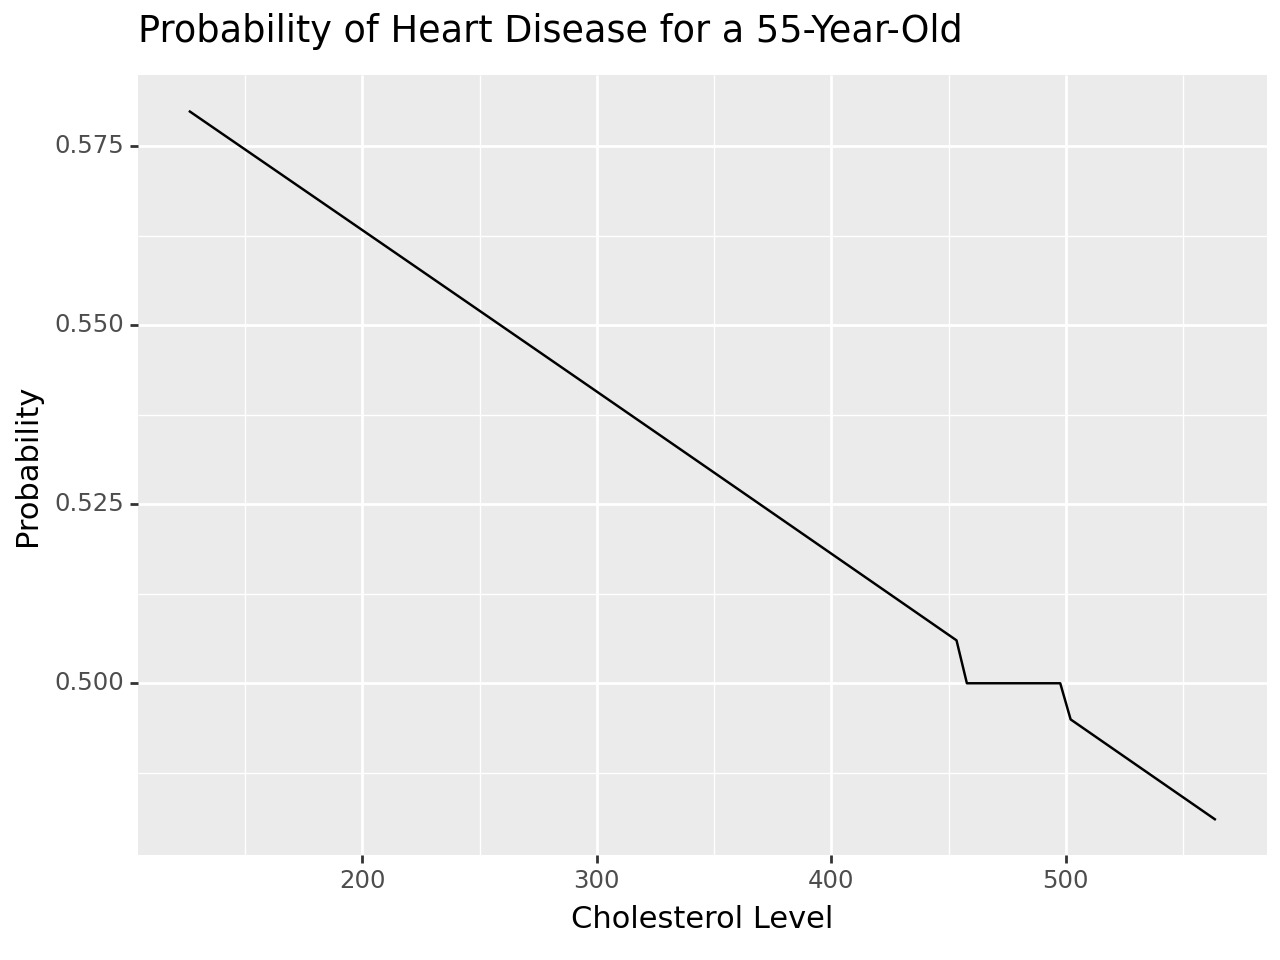

<Figure Size: (640 x 480)>

In [35]:
# Optimal C value pipeline
svc_optimal = Pipeline(
    [
        ('preprocessing', ct),
        ('svc_classifier', SVC(kernel='linear',
                               probability = True,
                               C = best_C))
    ]
)

# Fitting the model
svc_fit = svc_optimal.fit(X, y)

# Probabilities and plotting
probabilities_svc = svc_optimal.predict_proba(X_plot)[:, 1]

plot_data_svc = pd.DataFrame({'Cholesterol Level': cholesterol_range, 'Probability of Heart Disease': probabilities_svc})

# Graphing
(ggplot(plot_data_svc, aes(x='Cholesterol Level',
                       y='Probability of Heart Disease')) +
 geom_line() +
 labs(title='Probability of Heart Disease for a 55-Year-Old',
      x='Cholesterol Level',
      y='Probability')
)

In [46]:
svc_fit.named_steps['svc_classifier'].coef_

array([[-0.60125314, -0.19418837]])

In [48]:
svc_fit.named_steps['svc_classifier'].intercept_
(1 - 0.311 + 0.601*55)/-0.194

-173.93814432989691

predicted-HD = 0.311 - 0.601*age - 0.194*chol

For someone aged 55, chol calculation:
(1 - 0.311 + 0.601*55)/-0.194 = 173.94

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [51]:
#Logistic Regression Values
print(f"Log Reg")
log_intercept = log_pipe_fitted.named_steps["logistic_regression"].intercept_[0]
print(log_intercept)
coeff_age_log = log_pipe_fitted.named_steps["logistic_regression"].coef_[0][0]
print(coeff_age_log)
coeff_chol_log = log_pipe_fitted.named_steps["logistic_regression"].coef_[0][1]
print(coeff_chol_log)

#LDA Values
print(f"LDA")
lda_intercept = lda_fit.named_steps["lda"].intercept_[0]
print(lda_intercept)
coeff_age_lda = lda_fit.named_steps["lda"].coef_[0][0]
print(coeff_age_lda)
coeff_chol_lda = lda_fit.named_steps["lda"].coef_[0][1]
print(coeff_chol_lda)

#SVC Values
print(f"SVC")
svc_intercept = svc_fit.named_steps["svc_classifier"].intercept_[0]
print(svc_intercept)
coeff_age_svc = svc_fit.named_steps["svc_classifier"].coef_[0][0]
print(coeff_age_svc)
coeff_chol_svc = svc_fit.named_steps["svc_classifier"].coef_[0][1]
print(coeff_chol_svc)

Log Reg
0.2702433596330412
-0.4276608994232138
-0.09574186756792046
LDA
0.26973565151685097
-0.4344658185163842
-0.09493491278066934
SVC
0.31173804465299343
-0.6012531420803633
-0.19418836818453755


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
heart['diagnosis'] = label_encoder.fit_transform(heart['diagnosis'])

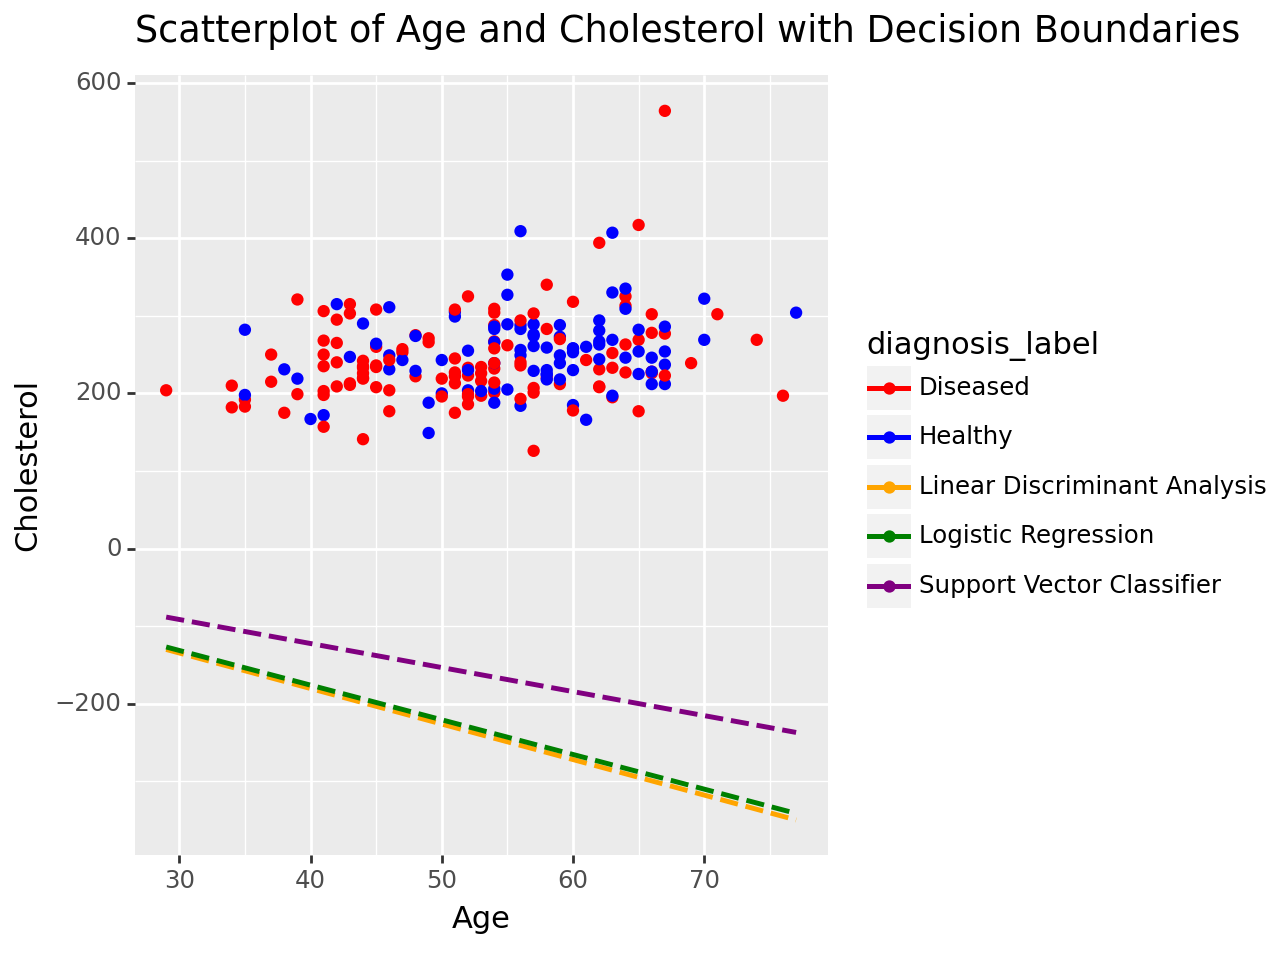

<Figure Size: (640 x 480)>

In [57]:
# Reshape data for plotnine
heart['diagnosis_label'] = heart['diagnosis'].map({0: 'Healthy', 1: 'Diseased'})
melted_heart = heart.melt(id_vars=['age', 'diagnosis_label'], value_vars=['chol'])

# Create decision boundary data
x_lr = np.linspace(min(heart['age']), max(heart['age']), 100)
y_lr = (-log_intercept - coeff_age_log * x_lr) / coeff_chol_log
lr_df = pd.DataFrame({'age': x_lr, 'chol': y_lr, 'method': 'Logistic Regression'})

y_lda = (-lda_intercept - coeff_age_lda * x_lr) / coeff_chol_lda
lda_df = pd.DataFrame({'age': x_lr, 'chol': y_lda, 'method': 'Linear Discriminant Analysis'})

y_svc = (-svc_intercept - coeff_age_svc * x_lr) / coeff_chol_svc
svc_df = pd.DataFrame({'age': x_lr, 'chol': y_svc, 'method': 'Support Vector Classifier'})

boundary_df = pd.concat([lr_df, lda_df, svc_df])

# Plotting
(ggplot(melted_heart, aes(x='age', y='value', color='diagnosis_label')) +
    geom_point() +
    geom_line(aes(x='age', y='chol', color='method'), data=boundary_df, linetype='dashed', size=1) +
    scale_color_manual(values={'Healthy': 'blue', 'Diseased': 'red',
                               'Logistic Regression': 'green',
                               'Linear Discriminant Analysis': 'orange',
                               'Support Vector Classifier': 'purple'}) +
    labs(x='Age', y='Cholesterol', title='Scatterplot of Age and Cholesterol with Decision Boundaries') +
    theme(legend_position='right'))
